In [1]:
import datetime as dt
import subprocess
import requests
import urllib.request
import zipfile
import os
import shutil
import geopandas as gpd
from bs4 import BeautifulSoup
import urllib.request
from os import listdir
from os.path import isfile, join
import pandas as pd
import ee
import os
import glob
from zipfile import ZipFile

ee.Initialize()



In [2]:
ex = ['.shp', '.prj', '.dbf', '.shx']
file_paths = []
i=1

def zipshape(directory,export):
    for (root, directories, files) in os.walk(directory):
        for filename in files:
            if filename.endswith('.shp'):
                file_paths=[]
                filebase = filename.split('.')[0]
                try:
                    for things in ex:
                        if os.path.exists(os.path.join(root, filebase+things)):
                            filepath = os.path.join(root, filebase+things)
                            #print(filepath)
                            file_paths.append(filepath)
                    os.chdir(export)
                    if not os.path.exists(filebase+'.zip') and int(len(file_paths))==int(4):
                        with ZipFile(filebase+'.zip','w') as zip:
                            print("Creating zipped folder "+str(filebase)+'.zip'+' at '+str(export))
                            # writing each file one by one
                            for file in file_paths:
                                fname=os.path.basename(file)
                                zip.write(file,fname)
                    else:
                        print('File already exists: '+str(filebase+'.zip')+' SKIPPING')
                except:
                    pass

In [3]:
os.getcwd()
mypath = "../../../data/Shapefile"
#for soutther Africa the URL will be the follwoing 
#url = "https://fews.net/fews-data/333?tid=34&field_data_portal_date_start%5Bvalue%5D%5Byear%5D=2009&field_data_portal_date_start%5Bvalue%5D%5Bmonth%5D=1&field_data_portal_date_end%5Bvalue%5D%5Byear%5D=2020&field_data_portal_date_end%5Bvalue%5D%5Bmonth%5D=12&page={0}

In [ ]:
url_download_list_zip = []

for pagenum in range (0,100):
    # Main page url for east africa
    #url = "http://fews.net/fews-data/333?tid=23&field_data_portal_date_start%5Bvalue%5D%5Byear%5D=&field_data_portal_date_start%5Bvalue%5D%5Bmonth%5D=&field_data_portal_date_end%5Bvalue%5D%5Byear%5D=&field_data_portal_date_end%5Bvalue%5D%5Bmonth%5D=&page={0}".format(pagenum)
    url = "https://fews.net/fews-data/333?tid=34&field_data_portal_date_start%5Bvalue%5D%5Byear%5D=2009&field_data_portal_date_start%5Bvalue%5D%5Bmonth%5D=1&field_data_portal_date_end%5Bvalue%5D%5Byear%5D=2020&field_data_portal_date_end%5Bvalue%5D%5Bmonth%5D=12&page={0}".format(pagenum)

    print("Page number:" + str(pagenum))
    resp = urllib.request.urlopen(url)
    soup = BeautifulSoup(resp, from_encoding=resp.info().get_param('charset'))
    link_list = []
    
    # Find all links from main page
    for link in soup.find_all('a', href=True): 
        link_list.append(link['href'])
        
    # if it contains node, it mains that there is data on that page number
    if any("/node/" in s for s in link_list):
        
        # we only need the content link that links to the zipfile data (shapefiles)
        url_download_list = [s for s in link_list if "/content/" in s]
        
        #Find all zip files and on that link and save that in a list
        for downloadurl in url_download_list:
            resp = urllib.request.urlopen("http://fews.net/{0}".format(downloadurl))
            soup = BeautifulSoup(resp, "lxml", from_encoding=resp.info().get_param('charset'))
            
            link_list = []
            for link in soup.find_all('a', href=True): 
                link_list.append(link['href'])
            url_download_list_zip.append([s for s in link_list if ".zip" in s][0])  
    else:
        break
        
# zip occurs twice in the extracted website link list, remove duplicates:        
url_download_list_zip = list(set(url_download_list_zip))

In [ ]:
"""
Two important Notes if you use this link to download all the shapefiles in one go:
http://shapefiles.fews.net.s3.amazonaws.com/ALL_HFIC.zip', 'IPC_Shapefiles/ALL_HFIC.zip

It Won't include:
ML1, ML2 (which we use for the benchmark).

As so, I have manually downloaded each shapefile which are located in the folder ...

Using this script it will zip each of the files ready for uploading on the GEE

"""
# Convert files to zips in the folder

zipshape("C:/Users/ATeklesadik/OneDrive - Rode Kruis/Documents/documents/ethiopia/foodsecurity/data/Shapefile/South_Africa_Assets",
         "C:/Users/ATeklesadik/OneDrive - Rode Kruis/Documents/documents/ethiopia/foodsecurity/data/Shapefile/South_Africa_Assets_Processed")

# order into three folders 

In [ ]:
for zipfile_url in url_download_list_zip:

    filename = zipfile_url.rsplit('/', 1)[-1]

    print("Downloading shapefile {0}".format(filename))

    urllib.request.urlretrieve('{0}'.format(zipfile_url), '{0}/South_Africa_Zips/{1}'.format(mypath2, filename))
    # Extract all files into a single folder:
    archive = zipfile.ZipFile('{0}/South_Africa_Zips/{1}'.format(mypath, filename), 'r')
    archive.extractall(path="{0}/South_Africa_Assets/".format(mypath))

In [ ]:
# order into three folders 
mypath2='C:/Users/ATeklesadik/OneDrive - Rode Kruis/Documents/documents/ethiopia/foodsecurity/data/Shapefile'
onlyfiles = [f for f in listdir(mypath2 + "/South_Africa_Assets_Processed/") if isfile(join(mypath2 + "/South_Africa_Assets_Processed/", f))]
 
try:
    shutil.rmtree(mypath2 + r"/CS") 
    shutil.rmtree(mypath2 + r"/ML1") 
    shutil.rmtree(mypath2 + r"/ML2") 
except:
    print("directory doesn't excist yet")
os.mkdir(mypath2 + r"/CS")
os.mkdir(mypath2 + r"/ML1")
os.mkdir(mypath2 + r"/ML2")

In [ ]:
CS = [s for s in onlyfiles if "CS" in s]

for file in CS:
    shutil.move(mypath2 + "/South_Africa_Assets_Processed/" + file, mypath2 + "/CS")

os.rename(mypath2 + r"/CS/EA201702_CS.zip", mypath2 + r"/CS/EA_201702_CS.zip")
ML1 = [s for s in onlyfiles if "ML1" in s]

for file in ML1:
    shutil.move(mypath2 + "/South_Africa_Assets_Processed/" + file, mypath2 + "/ML1")
    
os.rename(mypath2 + "/ML1/EA201702_ML1.zip", mypath2 + "/ML1/EA_201702_ML1.zip")

In [28]:
mypath2='C:/Users/ATeklesadik/OneDrive - Rode Kruis/Documents/documents/ethiopia/foodsecurity/data/Shapefile'

CS = [f for f in listdir(mypath2 + "/CS/") if isfile(join(mypath2 + "/CS/", f))]
ML1 = [f for f in listdir(mypath2 + "/ML1/") if isfile(join(mypath2 + "/ML1/", f))]
ML2 = [f for f in listdir(mypath2 + "/ML2/") if isfile(join(mypath2 + "/ML2/", f))]
path='C:/Users/ATeklesadik/OneDrive - Rode Kruis/Documents/documents/ethiopia/foodsecurity/data/'

ZMW_lzh = gpd.read_file(mypath2+'/ZMW/admin_2/pop_recalc.shp')
POSTO= gpd.read_file(mypath2+'/ZMW/ZW_LHZ_2011/ZW_LHZ_2011.shp')

In [29]:
CS_ = gpd.read_file('zip://' +mypath2 + "/CS/" +CS[-1])
gdf_lhz_cs_merged = gpd.sjoin(ZMW_lzh, CS_,how='left')  

C:\Users\ATeklesadik\anaconda3\envs\py36\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


In [53]:
ZMW_lzh.index=ZMW_lzh['ADM2_PCODE']

In [31]:
gdf_lhz_cs_merged

,Shape_Leng,Shape_Area,ADM2_EN,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,pp_sumsum,_sum,geometry,index_right,CS,HA0
0,6.243144,1.111672,Beitbridge,ZW1601,None,None,None,Matabeleland South,ZW16,Zimbabwe,ZW,2018-08-31,2018-09-11,None,91620.234131,82497.809891,"POLYGON ((29.90621 -21.26976, 29.91866 -21.276...",3,2.0,1.0
0,6.243144,1.111672,Beitbridge,ZW1601,None,None,None,Matabeleland South,ZW16,Zimbabwe,ZW,2018-08-31,2018-09-11,None,91620.234131,82497.809891,"POLYGON ((29.90621 -21.26976, 29.91866 -21.276...",4,3.0,0.0
1,0.391538,0.007823,Beitbridge Urban,ZW1622,None,None,None,Matabeleland South,ZW16,Zimbabwe,ZW,2018-08-31,2018-09-11,None,31703.394775,43277.149144,"POLYGON ((29.98811 -22.15274, 30.02215 -22.159...",4,3.0,0.0
2,3.274864,0.447512,Bikita,ZW1801,None,None,None,Masvingo,ZW18,Zimbabwe,ZW,2018-08-31,2018-09-11,None,177280.995422,177287.110881,"POLYGON ((31.97352 -19.82110, 31.97389 -19.825...",2,2.0,0.0
2,3.274864,0.447512,Bikita,ZW1801,None,None,None,Masvingo,ZW18,Zimbabwe,ZW,2018-08-31,2018-09-11,None,177280.995422,177287.110881,"POLYGON ((31.97352 -19.82110, 31.97389 -19.825...",3,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,3.069243,0.214057,Zvishavane,ZW1708,None,None,None,Midlands,ZW17,Zimbabwe,ZW,2018-08-31,2018-09-11,None,96692.686584,78468.154918,"POLYGON ((30.14456 -19.96284, 30.14435 -19.964...",2,2.0,0.0
89,3.069243,0.214057,Zvishavane,ZW1708,None,None,None,Midlands,ZW17,Zimbabwe,ZW,2018-08-31,2018-09-11,None,96692.686584,78468.154918,"POLYGON ((30.14456 -19.96284, 30.14435 -19.964...",3,2.0,1.0
89,3.069243,0.214057,Zvishavane,ZW1708,None,None,None,Midlands,ZW17,Zimbabwe,ZW,2018-08-31,2018-09-11,None,96692.686584,78468.154918,"POLYGON ((30.14456 -19.96284, 30.14435 -19.964...",4,3.0,0.0
90,0.379343,0.005395,Zvishavane Urban,ZW1725,None,None,None,Midlands,ZW17,Zimbabwe,ZW,2018-08-31,2018-09-11,None,32390.126465,49383.600468,"POLYGON ((30.03948 -20.27616, 30.04983 -20.282...",3,2.0,1.0


In [33]:
df=gdf_lhz_cs_merged[['ADM2_EN','CS','pp_sumsum']].query('CS < 6')
df

,ADM2_EN,CS,pp_sumsum
0,Beitbridge,2.0,91620.234131
0,Beitbridge,3.0,91620.234131
1,Beitbridge Urban,3.0,31703.394775
2,Bikita,2.0,177280.995422
2,Bikita,2.0,177280.995422
...,...,...,...
89,Zvishavane,2.0,96692.686584
89,Zvishavane,2.0,96692.686584
89,Zvishavane,3.0,96692.686584
90,Zvishavane Urban,2.0,32390.126465


In [57]:
df['pop']=ZMW_lzh['pp_sumsum']
 

ADM2_PCODE
ZW1601     91620.234131
ZW1622     31703.394775
ZW1801    177280.995422
ZW1201    190437.736816
ZW1221     15425.579268
              ...      
ZW1522     10547.605077
ZW1807    194303.778625
ZW1406    328104.219543
ZW1708     96692.686584
ZW1725     32390.126465
Name: pp_sumsum, Length: 91, dtype: float64

In [58]:
###############3 zwb
CS1 = [f for f in listdir(mypath2 + "/CS/") if isfile(join(mypath2 + "/CS/", f))]


df_list=list()
for file in CS:
    CS_ = gpd.read_file('zip://' +mypath2 + "/CS/" +file)
    #gdf_lhz_cs_merged = gpd.sjoin(moz_lzh, CS_,how='left')
    gdf_lhz_cs_merged = gpd.sjoin(ZMW_lzh, CS_,how='left')    
    #df=gdf_lhz_cs_merged[['FNID','CS']].query('CS < 6')
    df=gdf_lhz_cs_merged[['ADM2_PCODE','CS','pp_sumsum']].query('CS < 6')
    df1=df.reset_index().groupby('ADM2_PCODE')['CS'].max()
    df=pd.DataFrame(df1)
    df['pp_sumsum']=ZMW_lzh['pp_sumsum']
    x=file.split('_')[1] 
    df['Date']=dt.datetime(int(x[:4]),int(x[4:]),1).strftime("%Y-%m-%d")
    df['year']=int(x[:4])
    df_list.append(df.query('CS != "NaN"'))
    
df2 = pd.concat(df_list)

C:\Users\ATeklesadik\anaconda3\envs\py36\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
C:\Users\ATeklesadik\anaconda3\envs\py36\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
C:\Users\ATeklesadik\anaconda3\envs\py36\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
C:\Users\ATeklesadik\anaconda3\envs\py36\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
C:\Users\ATeklesadik\anaconda3\envs\py36\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
C:\Users\ATeklesadik\anaconda3\envs\py36\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarnin

In [59]:
pd.

,CS,pp_sumsum,Date,year
ADM2_PCODE,,,,
ZW1021,1.0,5.211705e+05,2009-07-01,2009
ZW1101,1.0,2.678951e+05,2009-07-01,2009
ZW1102,1.0,1.517463e+05,2009-07-01,2009
ZW1103,1.0,3.426061e+05,2009-07-01,2009
ZW1104,1.0,3.317067e+05,2009-07-01,2009
...,...,...,...,...
ZW1822,3.0,8.375239e+03,2020-06-01,2020
ZW1921,3.0,1.508515e+06,2020-06-01,2020
ZW1922,3.0,2.663541e+05,2020-06-01,2020


C:\Users\ATeklesadik\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


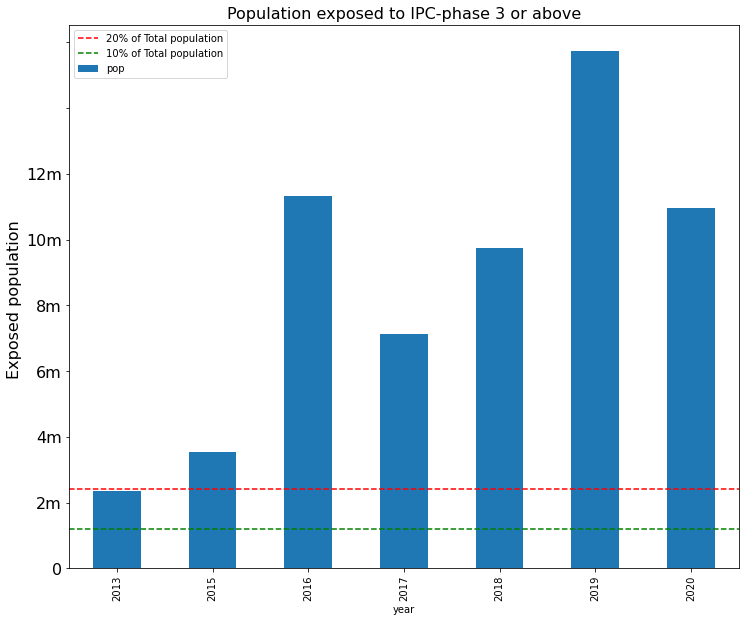

In [60]:
import matplotlib.pyplot as plt



fig, ax = plt.subplots(figsize = (12,10)) 
#ax.axis("off")
#gdf_lhz_cs_merged =gpd.overlay(moz_lzh, moz_lzh1, how='intersection', make_valid=True)
df_posto = df2.astype({"pp_sumsum": int})
df_posto['pop']= df_posto['pp_sumsum'] 
df2=df_posto.groupby(['CS','year']).sum().reset_index()
df2.query('CS>2').plot.bar(x='year',y= 'pop',ax=ax,legend=False)
 
#plt.clim(1,5) 
#POSTO.geometry.boundary.plot(color=None,edgecolor='black',linewidth = .1,ax=ax)
plt.title('Population exposed to IPC-phase 3 or above',fontsize='16')
#ax.set_xticks([0.1, 0.5, 0.7])
ax.set_yticklabels(['0','2m', '4m','6m','8m','10m' ,'12m'],fontsize='16')
ax.set_ylabel('Exposed population ',fontsize='16')
plt.axhline(y=6000000, color='r', linestyle='dashed', label='20% of Total population')
plt.axhline(y=3000000, color='g', linestyle='dashed', label='10% of Total population') 
plt.legend()

In [40]:
###############3 MOZAMBIQUE
CS1 = [f for f in listdir(mypath2 + "/CS/") if isfile(join(mypath2 + "/CS/", f))]

moz_lzh = gpd.read_file(mypath2+'/MOZ/MZ_LHZ_2013.shp')
POSTO= gpd.read_file(mypath2+'/MOZ/POSTO_ADMINISTRATIVO_E_POP_2017.shp')

df_list=list()
for file in CS[20:-1]:
    CS_ = gpd.read_file('zip://' +mypath2 + "/CS/" +file)
    #gdf_lhz_cs_merged = gpd.sjoin(moz_lzh, CS_,how='left')
    gdf_lhz_cs_merged = gpd.sjoin(POSTO, CS_,how='left')    
    #df=gdf_lhz_cs_merged[['FNID','CS']].query('CS < 6')
    df=gdf_lhz_cs_merged#[['Posto','CS','pp_sum']].query('CS < 6')
    df=df.loc[df.reset_index().groupby(['Posto'])['CS'].idxmax()]
    x=file.split('_')[1] 
    df['Date']=dt.datetime(int(x[:4]),int(x[4:]),1).strftime("%Y-%m-%d")
    df['year']=int(x[:4])
    df_list.append(df.query('CS != "NaN"'))
    
df1 = pd.concat(df_list)

C:\Users\ATeklesadik\anaconda3\envs\py36\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Int64Index([459, 458], dtype='int64'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [ ]:
############### ETHOPIA
ETH_lzh = gpd.read_file(path+'/Shapefile/Ethiopia/ET_LHZ_2009/ET_LHZ_2009.shp')
WOREDA= gpd.read_file(path+'/Shapefile/Ethiopia/adm_lvl3/Eth_Woreda_2013.shp')
 

pop_ETH = pd.read_csv(path + "/Shapefile/Ethiopia/Indicators_3_population.csv", sep = ";")

DATA_ETH = pd.read_csv(path + "/Processed Data/df_master_03092020.csv", sep = ";")

WOREDA['pcode']=WOREDA['WOR_P_CODE'].apply(lambda x: 'ET'+x)
WOREDA=WOREDA.merge(pop_ETH, left_on='pcode', right_on='pcode')
WOREDA.crs = {'init' :'epsg:20137'}
WOREDA = WOREDA.to_crs({'init': 'epsg:4326'})  

CS1 = [f for f in listdir(mypath2 + "/CS/") if isfile(join(mypath2 + "/CS/", f))]


df_list=list()
for file in CS1:
    CS_ = gpd.read_file('zip://' +mypath2 + "/CS/" +file)
    #gdf_lhz_cs_merged = gpd.sjoin(moz_lzh, CS_,how='left')
    gdf_lhz_cs_merged = gpd.sjoin(WOREDA, CS_,how='left')    
    #df=gdf_lhz_cs_merged[['FNID','CS']].query('CS < 6')
    df=gdf_lhz_cs_merged[['pcode','CS','population']].query('CS < 6')
   
    df=df.loc[df.reset_index().groupby(['pcode'])['CS'].idxmax()]
    x=file.split('_')[1] 
    df['Date']=dt.datetime(int(x[:4]),int(x[4:]),1).strftime("%Y-%m-%d")
    df['year']=int(x[:4])
    df_list.append(df.query('CS != "NaN"'))
    
df1 = pd.concat(df_list)

In [ ]:
# Merge conflict events with regions they occurred in
fig, ax = plt.subplots(figsize = (12,10)) 
#ax.axis("off")
#gdf_lhz_cs_merged =gpd.overlay(moz_lzh, moz_lzh1, how='intersection', make_valid=True)
df_posto = df_posto.astype({"pp_sum": int})
df_posto['pop']= df_posto['pp_sum'] 
df2=df_posto.groupby(['CS','year']).sum().reset_index()
df2.query('CS>2').plot.bar(x='year',y= 'pop',ax=ax,legend=False)
 
#plt.clim(1,5) 
#POSTO.geometry.boundary.plot(color=None,edgecolor='black',linewidth = .1,ax=ax)
plt.title('Population exposed to IPC-phase 3 or above',fontsize='16')
#ax.set_xticks([0.1, 0.5, 0.7])
ax.set_yticklabels(['0','2m', '4m','6m','8m','10m' ,'12m'],fontsize='16')
ax.set_ylabel('Exposed population ',fontsize='16')
plt.axhline(y=6000000, color='r', linestyle='dashed', label='20% of Total population')
plt.axhline(y=3000000, color='g', linestyle='dashed', label='10% of Total population') 
plt.legend()